### **Import library**

In [1]:
import pandas as pd
import string
import re
import nltk
import tensorflow as tf
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### **Read dataset**

In [2]:
df = pd.read_csv("/content/drive/MyDrive/archive/Corona_NLP_tweet.csv", encoding="ISO-8859-1")
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [3]:
df['Sentiment'].unique()

array(['Neutral', 'Positive', 'Negative'], dtype=object)

### **Text Preprocessing**

In [4]:
df = df.drop(columns=['UserName', 'ScreenName', 'Location', 'TweetAt',])
df

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Negative
...,...,...
41152,Airline pilots offering to stock supermarket s...,Neutral
41153,Response to complaint not provided citing COVI...,Negative
41154,You know itÂs getting tough when @KameronWild...,Positive
41155,Is it wrong that the smell of hand sanitizer i...,Neutral


In [5]:
stop_words = set(stopwords.words('english'))

def tokenize(tweet):
  tweet = re.sub(r'http\S+', '', tweet)
  tokenizer = nltk.RegexpTokenizer(r"\w+")
  tweet = tokenizer.tokenize(tweet)
  # tweet = word_tokenize(tweet)
  tweet = [word.lower() for word in tweet if word.isalnum()]
  tweet = [item for item in tweet if not item in stop_words]
  return tweet

df['OriginalTweet'] = df['OriginalTweet'].apply(tokenize)
df['OriginalTweet'].head()

0                                 [menyrbie, chrisitv]
1    [advice, talk, neighbours, family, exchange, p...
2    [coronavirus, australia, woolworths, give, eld...
3    [food, stock, one, empty, please, panic, enoug...
4    [ready, go, supermarket, covid19, outbreak, pa...
Name: OriginalTweet, dtype: object

In [6]:
sentiment = pd.get_dummies(df.Sentiment)
df = pd.concat([df, sentiment], axis=1)
df = df.drop(columns='Sentiment')

df.head()

,OriginalTweet,Negative,Neutral,Positive
0,"[menyrbie, chrisitv]",0,1,0
1,"[advice, talk, neighbours, family, exchange, p...",0,0,1
2,"[coronavirus, australia, woolworths, give, eld...",0,0,1
3,"[food, stock, one, empty, please, panic, enoug...",0,0,1
4,"[ready, go, supermarket, covid19, outbreak, pa...",1,0,0


In [7]:
tweets = df['OriginalTweet'].values
label = df[['Negative', 'Neutral', 'Positive']].values

### **Split Data**

In [8]:
tweet_train, tweet_test, label_train, label_test = train_test_split(tweets, label, test_size=0.2)

### **Tokenization**

In [9]:
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(tweet_train)

sequence_train = tokenizer.texts_to_sequences(tweet_train)
sequence_test = tokenizer.texts_to_sequences(tweet_test)

padded_train = pad_sequences(sequence_train)
padded_test = pad_sequences(sequence_test)

### **Model Sequential**

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax'),
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### **Callbacks**

In [11]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.91) and logs.get('val_accuracy')>0.80:
      print("\nAkurasi telah mencapai", logs.get('accuracy'))
      self.model.stop_training = True
callbacks = myCallback()

###**Training**

In [12]:
num_epochs = 50
history = model.fit(padded_train, label_train, epochs=num_epochs,
                    validation_data=(padded_test, label_test),
                    verbose=2, callbacks=[callbacks],
                    batch_size=128)

Epoch 1/50
258/258 - 22s - loss: 0.8897 - accuracy: 0.5612 - val_loss: 0.6520 - val_accuracy: 0.7314 - 22s/epoch - 84ms/step
Epoch 2/50
258/258 - 12s - loss: 0.5279 - accuracy: 0.8074 - val_loss: 0.5248 - val_accuracy: 0.8106 - 12s/epoch - 45ms/step
Epoch 3/50
258/258 - 11s - loss: 0.4198 - accuracy: 0.8596 - val_loss: 0.5286 - val_accuracy: 0.8130 - 11s/epoch - 44ms/step
Epoch 4/50
258/258 - 11s - loss: 0.3777 - accuracy: 0.8778 - val_loss: 0.5211 - val_accuracy: 0.8205 - 11s/epoch - 44ms/step
Epoch 5/50
258/258 - 11s - loss: 0.3484 - accuracy: 0.8907 - val_loss: 0.5301 - val_accuracy: 0.8201 - 11s/epoch - 44ms/step
Epoch 6/50
258/258 - 11s - loss: 0.3312 - accuracy: 0.8973 - val_loss: 0.5540 - val_accuracy: 0.8124 - 11s/epoch - 44ms/step
Epoch 7/50
258/258 - 12s - loss: 0.3141 - accuracy: 0.9041 - val_loss: 0.5677 - val_accuracy: 0.8164 - 12s/epoch - 48ms/step
Epoch 8/50
258/258 - 11s - loss: 0.2992 - accuracy: 0.9092 - val_loss: 0.5914 - val_accuracy: 0.8151 - 11s/epoch - 44ms/step


## **Plot**

### **Plot Loss**

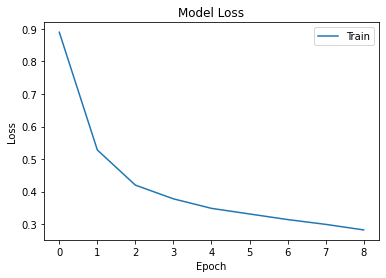

In [13]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

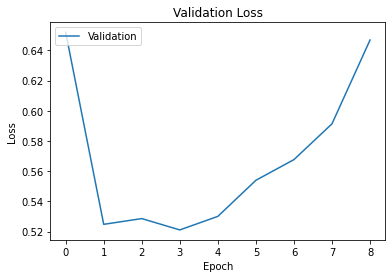

In [14]:
plt.plot(history.history['val_loss'])
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')

### **Plot Accuracy**

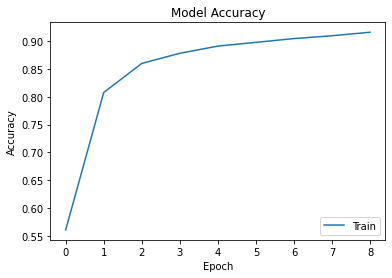

In [15]:
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='lower right')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

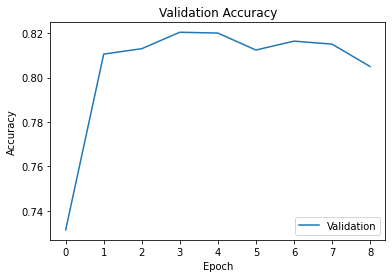

In [16]:
plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='lower right')
plt.show